# Lecture 22: Thermostatting

## Learning Objectives

By the end of this lecture, you should be able to:

1. Explain the concept of thermostatting in molecular dynamics simulations and its importance in maintaining constant temperature.
2. Describe how the Andersen thermostat works and its impact on the system's dynamics.
3. Implement the velocity Verlet algorithm combined with the Andersen thermostat in a 2D molecular dynamics simulation.
4. Analyze the effects of thermostatting on energy conservation and temperature control in simulations.

## Setting the *Computational* Thermostat

In molecular dynamics simulations, we often want to simulate a system at a **constant temperature**, corresponding to the canonical ensemble (NVT ensemble). However, when we numerically integrate Newton's equations of motion, the total energy of the system is conserved, leading to a microcanonical ensemble (NVE ensemble). To model real-world systems where temperature is controlled, we need to introduce **thermostats** that adjust the kinetic energy of the particles to maintain the desired temperature.

Thermostatting involves coupling the system to an external **heat bath**, which can exchange energy with the system. This process allows the simulation to sample configurations according to the canonical distribution, enabling the study of temperature-dependent properties and phase behavior.

## Andersen Thermostat

The Andersen thermostat is a stochastic method introduced by [Hans C. Andersen in 1980](https://doi.org/10.1063/1.439486) to maintain a constant temperature in MD simulations. It simulates the effect of collisions with an imaginary heat bath by randomly reassigning particle velocities, thus mimicking interactions with a thermal reservoir.

The key idea is to occasionally interrupt the deterministic trajectory of particles by "collisions" with the heat bath:

1. At each time step, each particle has a probability $\nu \Delta t$ of colliding with the heat bath, where $\nu$ is the collision frequency.
2. When a collision occurs, the particle's velocity is reassigned from the Maxwell-Boltzmann distribution at the desired temperature $T$.
3. Particles not colliding continue their motion according to Newton's laws.

This approach maintains the correct canonical distribution of particle velocities and allows the system to equilibrate at the desired temperature.

```{note}
The Andersen thermostat disrupts the conservation of total momentum because velocities are randomly reassigned without regard to the system's overall momentum. This can affect properties dependent on momentum conservation, such as diffusion coefficients and flow behavior. If preserving momentum is critical for your simulation, consider using thermostats like the Nosé-Hoover thermostat, which conserves momentum while controlling temperature.
```

## Velocity Verlet Algorithm

The velocity Verlet algorithm is an integration scheme that updates both positions and velocities in a time-symmetric way, offering improved numerical stability and energy conservation compared to basic Verlet integration.

```{admonition} Algorithm Steps
:class: tip

1. **Position Update:**

   $$
   \mathbf{r}(t + \Delta t) = \mathbf{r}(t) + \mathbf{v}(t)\Delta t + \frac{\mathbf{F}(t)}{2m}\Delta t^2
   $$
2. **Compute Forces:**
   Calculate $\mathbf{F}(t + \Delta t)$ based on the updated positions $\mathbf{r}(t + \Delta t)$.
3. **Velocity Update:**

   $$
   \mathbf{v}(t + \Delta t) = \mathbf{v}(t) + \frac{\mathbf{F}(t) + \mathbf{F}(t + \Delta t)}{2m}\Delta t
   $$
```

This method ensures that the positions and velocities are updated consistently, providing accurate trajectories for the particles.

## Velocity Verlet with Andersen Thermostat

When combining the velocity Verlet algorithm with the Andersen thermostat, the velocity update step is adjusted to include stochastic collisions.

```{admonition} Modified Velocity Update
:class: tip

**After the standard velocity update,** apply the Andersen thermostat:

- For each particle, generate a random number $r$ between 0 and 1.
- If $r < \nu \Delta t$, reassign the particle's velocity $\mathbf{v}(t + \Delta t)$ from the Maxwell-Boltzmann distribution.

The modified velocity update step becomes:

$$
\mathbf{v}(t + \Delta t) = \mathbf{v}(t) + \frac{\mathbf{F}(t) + \mathbf{F}(t + \Delta t)}{2m}\Delta t + \mathbf{R}(t)
$$

where $\mathbf{R}(t)$ is a random vector that is non-zero only if a collision occurs.
```

### Drawing Random Velocities from a Maxwell-Boltzmann Velocity Distribution

To draw random velocities from a Maxwell-Boltzmann velocity distribution at the desired temperature, we can use `numpy.random.normal` to generate random numbers from a normal distribution and then scale them to have the desired temperature. The Maxwell-Boltzmann velocity distribution for a single dimension is given by

$$
f_v(v_x) = \sqrt{\frac{m}{2\pi k_\text{B}T}}\exp\left(-\frac{mv_x^2}{2k_\text{B}T}\right)
$$

where $m$ is the mass of the particle, $k_\text{B}$ is the Boltzmann constant, and $T$ is the temperature. The random velocities can be drawn from this distribution by generating random numbers from a normal distribution with mean 0 and standard deviation $\sqrt{k_\text{B}T/m}$.

## Example: Andersen Thermostat in 2D

Let's implement the Andersen thermostat in 2D for a system of particles in a box. We will use the Lennard-Jones potential to calculate the forces between the particles.

### Initialization

First, we will define a function to initialize the positions and velocities of the particles.

In [1]:
import numpy as np
np.random.seed(5)

def initialize_particles(n_particles, box_size, temperature):
    # Place the particles on a square lattice
    n_side = int(np.ceil(np.sqrt(n_particles)))
    positions = np.zeros((n_particles, 2))
    for i in range(n_particles):
        x = i % n_side + 0.5
        y = i // n_side + 0.5
        positions[i] = [x, y]
    positions = positions * box_size / n_side

    # Give the particles random velocities
    velocities = np.random.uniform(-0.5, 0.5, (n_particles, 2))

    # Calculate the center of mass velocity
    v_com = np.sum(velocities, axis=0) / n_particles

    # Subtract the center of mass velocity from the velocities
    velocities -= v_com

    # Scale the velocities to have the desired temperature
    v2 = np.sum(velocities**2)
    scale_factor = np.sqrt(2 * n_particles * temperature / v2)
    velocities *= scale_factor

    return positions, velocities

### Plotting the Initial Particle Positions and Velocities

Let's plot the initial positions and velocities of the particles.

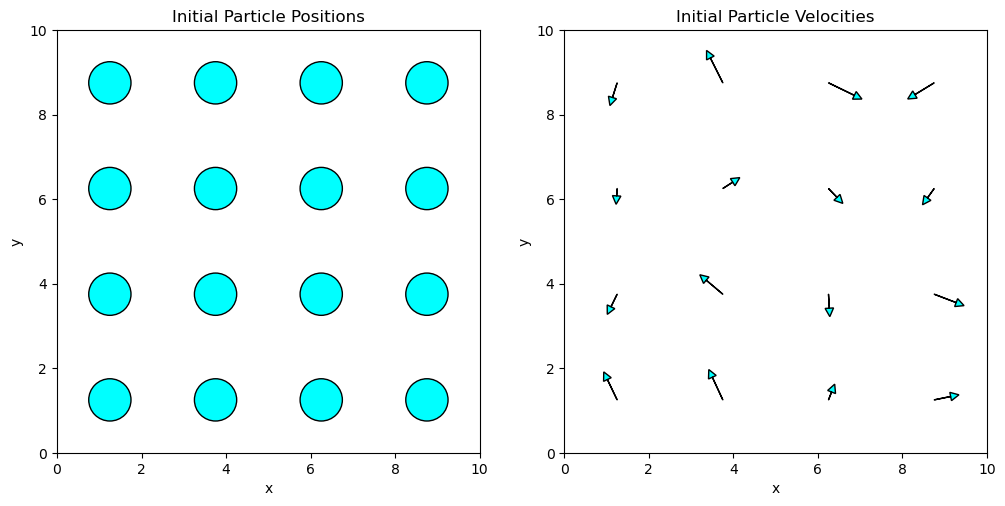

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

def plot_positions(positions, ax, title):
    for i in range(len(positions)):
        ax.add_patch(Circle(positions[i], 0.5, fc='cyan', ec='black'))
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)
    ax.set_aspect('equal')
    return ax

def plot_vectors(positions, vectors, ax, title):
    for i in range(len(positions)):
        ax.arrow(positions[i, 0], positions[i, 1], vectors[i, 0], vectors[i, 1], head_width=0.2, head_length=0.2, fc='cyan', ec='black')
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(0, box_size)
    ax.set_ylim(0, box_size)
    ax.set_aspect('equal')
    return ax

n_particles = 16
box_size = 10
temperature = 0.1

positions, velocities = initialize_particles(n_particles, box_size, temperature)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plot_positions(positions, axs[0], 'Initial Particle Positions')
plot_vectors(positions, velocities, axs[1], 'Initial Particle Velocities')

plt.show()

### Calculating the Forces

Next, we will define functions to calculate the Lennard-Jones potential and forces between the particles.

In [3]:
# Lennard-Jones potential
def U(r, epsilon=1.0, sigma=1.0):
    return 4 * epsilon * ((sigma / r)**12 - (sigma / r)**6)

# Lennard-Jones force
def F(r, epsilon=1.0, sigma=1.0):
    return 24 * epsilon * (2 * (sigma / r)**12 - (sigma / r)**6) / r

# Calculate the forces between the particles
def calculate_forces(positions, box_size, epsilon=1.0, sigma=1.0):
    n_particles = len(positions)
    forces = np.zeros((n_particles, 2))
    potential_energy = 0

    for i in range(n_particles):
        for j in range(i + 1, n_particles):
            r = np.linalg.norm(positions[i] - positions[j])
            potential_energy += U(r, epsilon, sigma)
            f = F(r, epsilon, sigma) * (positions[i] - positions[j]) / r
            forces[i] += f
            forces[j] -= f

    return forces, potential_energy

### Plotting the Initial Forces

Let's calculate the forces between the particles and plot the initial forces.

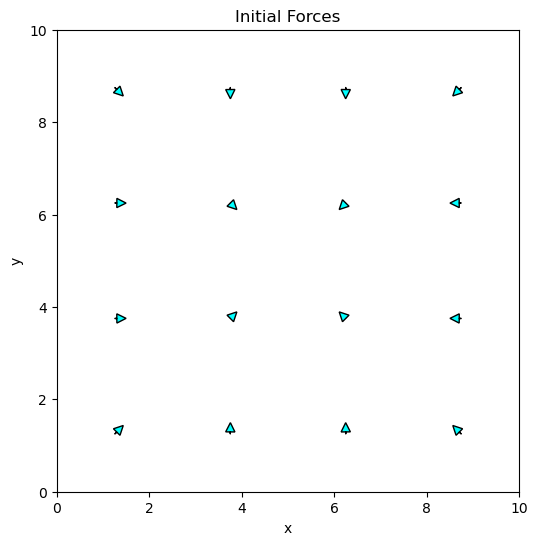

In [4]:
forces, _ = calculate_forces(positions, box_size)

fig, ax = plt.subplots(figsize=(6, 6))

plot_vectors(positions, forces, ax, 'Initial Forces')

plt.show()

### Velocity Verlet Algorithm with Andersen Thermostat

Now, we will implement the velocity Verlet algorithm with the Andersen thermostat.

In [5]:
def velocity_verlet(positions, velocities, forces, mass, box_size, temperature, dt, coupling_constant, epsilon=1.0, sigma=1.0, k_B=1.0):
    # Update positions based on current velocities and forces
    positions += velocities * dt + forces / (2 * mass) * dt**2

    # Apply periodic boundary conditions or walls (if applicable)
    # Here, we use walls by reflecting particles that cross the boundaries
    for i in range(len(positions)):
        # Check x-coordinate boundaries
        if positions[i, 0] < sigma / 2 or positions[i, 0] > box_size - sigma / 2:
            # Reflect position
            positions[i, 0] = np.clip(positions[i, 0], sigma / 2, box_size - sigma / 2)
            # Reverse velocity component
            velocities[i, 0] *= -1
        # Check y-coordinate boundaries
        if positions[i, 1] < sigma / 2 or positions[i, 1] > box_size - sigma / 2:
            positions[i, 1] = np.clip(positions[i, 1], sigma / 2, box_size - sigma / 2)
            velocities[i, 1] *= -1

    # Compute new forces based on updated positions
    forces, potential_energy = calculate_forces(positions, box_size, epsilon, sigma)

    # Update velocities with average of old and new forces
    velocities += forces / mass * dt

    # Apply the Andersen thermostat
    for i in range(len(velocities)):
        if np.random.rand() < coupling_constant:
            # Reassign velocity from Maxwell-Boltzmann distribution
            velocities[i] = np.random.normal(0, np.sqrt(k_B * temperature / mass), 2)

    # Calculate kinetic energy for diagnostics
    kinetic_energy = 0.5 * mass * np.sum(velocities**2)

    return positions, velocities, forces, potential_energy, kinetic_energy

### Running the Simulation

Finally, we will run the simulation and plot the final particle positions and velocities.

```{admonition} Parameter Selection
:class: tip

- **Coupling Constant ($\nu \Delta t$):** Determines the frequency of collisions with the heat bath. A higher value leads to more frequent temperature adjustments but can overly randomize particle motions.
- **Time Step ($\Delta t$):** Must be small enough to accurately capture particle dynamics. Typically, $\Delta t$ is chosen so that the maximum displacement per step is much smaller than the interaction range $\sigma$.
- **Number of Particles ($N$):** Affects statistical accuracy and computational cost. Larger systems provide better sampling of properties but require more computational resources.
```

```{admonition} Units and Constants
:class: tip

- **Mass ($m$)**: Set to 1 (arbitrary units) for simplicity.
- **Distance ($\sigma$)**: The characteristic length scale in the Lennard-Jones potential, set to 1.
- **Energy ($\epsilon$)**: The depth of the potential well in the Lennard-Jones potential, set to 1.
- **Boltzmann Constant ($k_B$)**: Set to 1 for reduced units.
- **Temperature ($T$)**: Expressed in units where $k_B = 1$.
```

In [6]:
# Simulation parameters
mass = 1
dt = 0.01
n_steps = 30000
coupling_constant = 0.1

# Initialize the particles
positions, velocities = initialize_particles(n_particles, box_size, temperature)

# Calculate the forces
forces, _ = calculate_forces(positions, box_size)

# Arrays to store the history of the simulation
positions_history = np.zeros((n_steps, n_particles, 2))
potential_energy_history = np.zeros(n_steps)
kinetic_energy_history = np.zeros(n_steps)

# Run the simulation
for i in range(n_steps):
    positions, velocities, forces, potential_energy, kinetic_energy = velocity_verlet(positions, velocities, forces, mass, box_size, temperature, dt, coupling_constant)
    positions_history[i] = positions
    potential_energy_history[i] = potential_energy
    kinetic_energy_history[i] = kinetic_energy

### Plotting the Final Particle Positions and Velocities

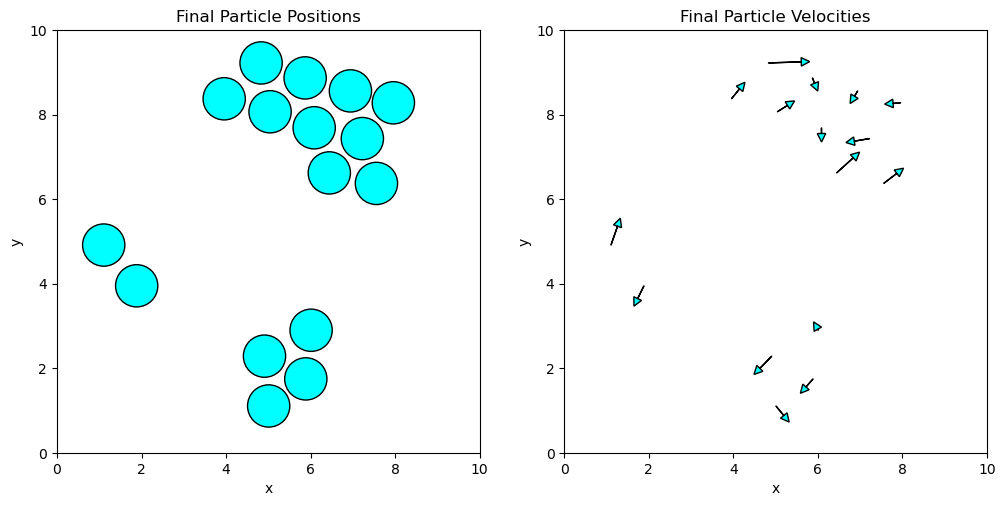

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

plot_positions(positions, axs[0], 'Final Particle Positions')
plot_vectors(positions, velocities, axs[1], 'Final Particle Velocities')

plt.show()

### Plotting and Analyzing Energy Conservation and Temperature Control

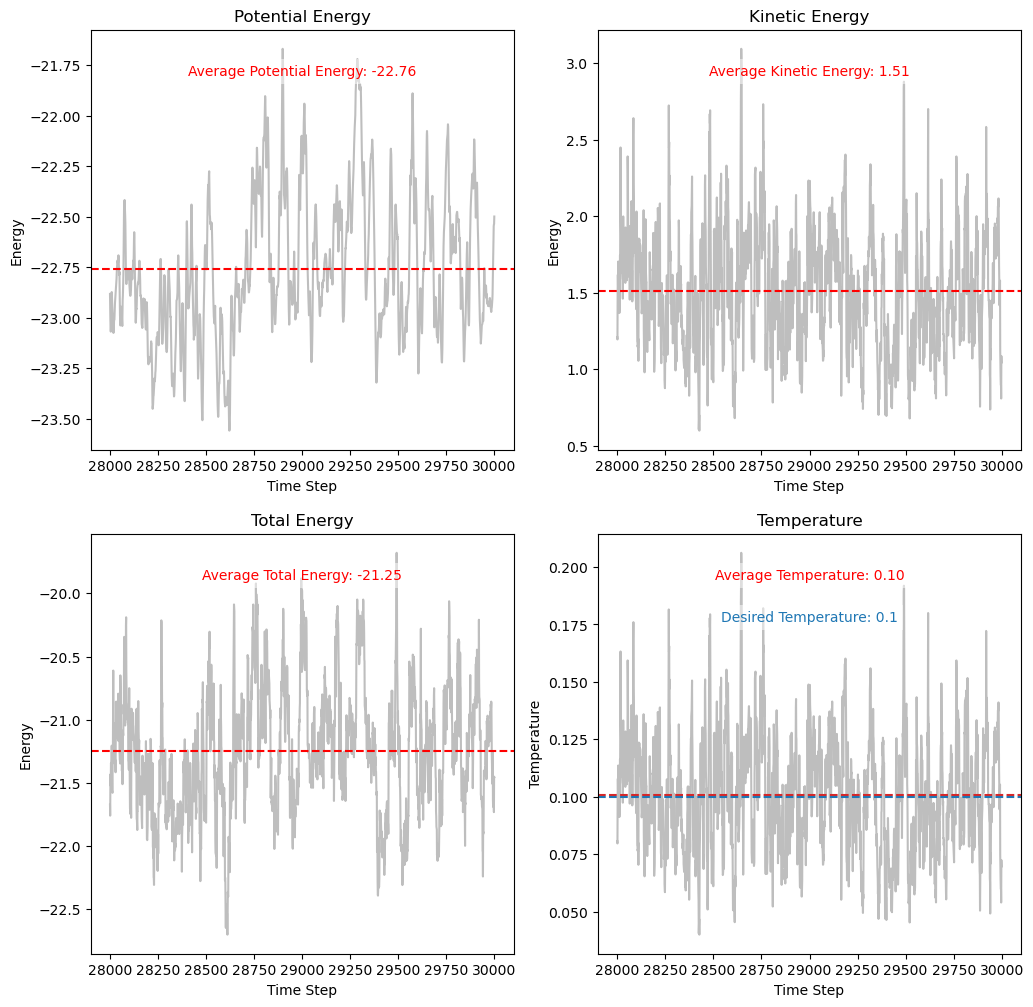

In [8]:
total_energy_history = potential_energy_history + kinetic_energy_history
temperature_history = 2 * kinetic_energy_history / (2 * n_particles - 2)

fig, axs = plt.subplot_mosaic([[0, 1], [2, 3]], figsize=(12, 12))

axs[0].plot(np.arange(n_steps - 2000, n_steps), potential_energy_history[-2000:], 'tab:gray', label='Potential Energy', alpha=0.5)
axs[0].set_title('Potential Energy')
axs[0].set_xlabel('Time Step')
axs[0].set_ylabel('Energy')
avg_potential_energy = np.mean(potential_energy_history[-2000:])
axs[0].axhline(y=avg_potential_energy, color='r', linestyle='--', label='Average Potential Energy')
axs[0].text(
    0.5, 0.9, 
    f'Average Potential Energy: {avg_potential_energy:.2f}', 
    ha='center', 
    va='center', 
    transform=axs[0].transAxes,
    color='red',
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
)

axs[1].plot(np.arange(n_steps - 2000, n_steps), kinetic_energy_history[-2000:], 'tab:gray', label='Kinetic Energy', alpha=0.5)
axs[1].set_title('Kinetic Energy')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Energy')
avg_kinetic_energy = np.mean(kinetic_energy_history[-2000:])
axs[1].axhline(y=avg_kinetic_energy, color='r', linestyle='--', label='Average Kinetic Energy')
axs[1].text(
    0.5, 0.9, 
    f'Average Kinetic Energy: {avg_kinetic_energy:.2f}', 
    ha='center', 
    va='center', 
    transform=axs[1].transAxes,
    color='red',
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
)

axs[2].plot(np.arange(n_steps - 2000, n_steps), total_energy_history[-2000:], 'tab:gray', label='Total Energy', alpha=0.5)
axs[2].set_title('Total Energy')
axs[2].set_xlabel('Time Step')
axs[2].set_ylabel('Energy')
avg_total_energy = np.mean(total_energy_history[-2000:])
axs[2].axhline(y=avg_total_energy, color='r', linestyle='--', label='Average Total Energy')
axs[2].text(
    0.5, 0.9, 
    f'Average Total Energy: {avg_total_energy:.2f}', 
    ha='center', 
    va='center', 
    transform=axs[2].transAxes,
    color='red',
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
)

axs[3].plot(np.arange(n_steps - 2000, n_steps), temperature_history[-2000:], 'tab:gray', label='Temperature', alpha=0.5)
axs[3].set_title('Temperature')
axs[3].set_xlabel('Time Step')
axs[3].set_ylabel('Temperature')
avg_temperature = np.mean(temperature_history[-2000:])
axs[3].axhline(y=avg_temperature, color='tab:red', linestyle='--', label='Average Temperature')
axs[3].text(
    0.5, 0.9, 
    f'Average Temperature: {avg_temperature:.2f}', 
    ha='center', 
    va='center', 
    transform=axs[3].transAxes,
    color='red',
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
)
axs[3].axhline(y=temperature, color='tab:blue', linestyle='--', label='Desired Temperature')
axs[3].text(
    0.5, 0.8, 
    f'Desired Temperature: {temperature}', 
    ha='center', 
    va='center', 
    transform=axs[3].transAxes,
    color='tab:blue',
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
)

plt.show()

The plots show that while the kinetic and potential energies fluctuate due to stochastic collisions, the total energy remains relatively stable. This indicates that the Andersen thermostat maintains the system's temperature without causing significant energy drift.

The temperature plot demonstrates that the system's temperature converges to the desired value ($T = 0.1$) over time. The fluctuations around the mean temperature are expected due to the finite size of the system and stochastic nature of the thermostat.

### Plotting and Analyzing Particle Dynamics

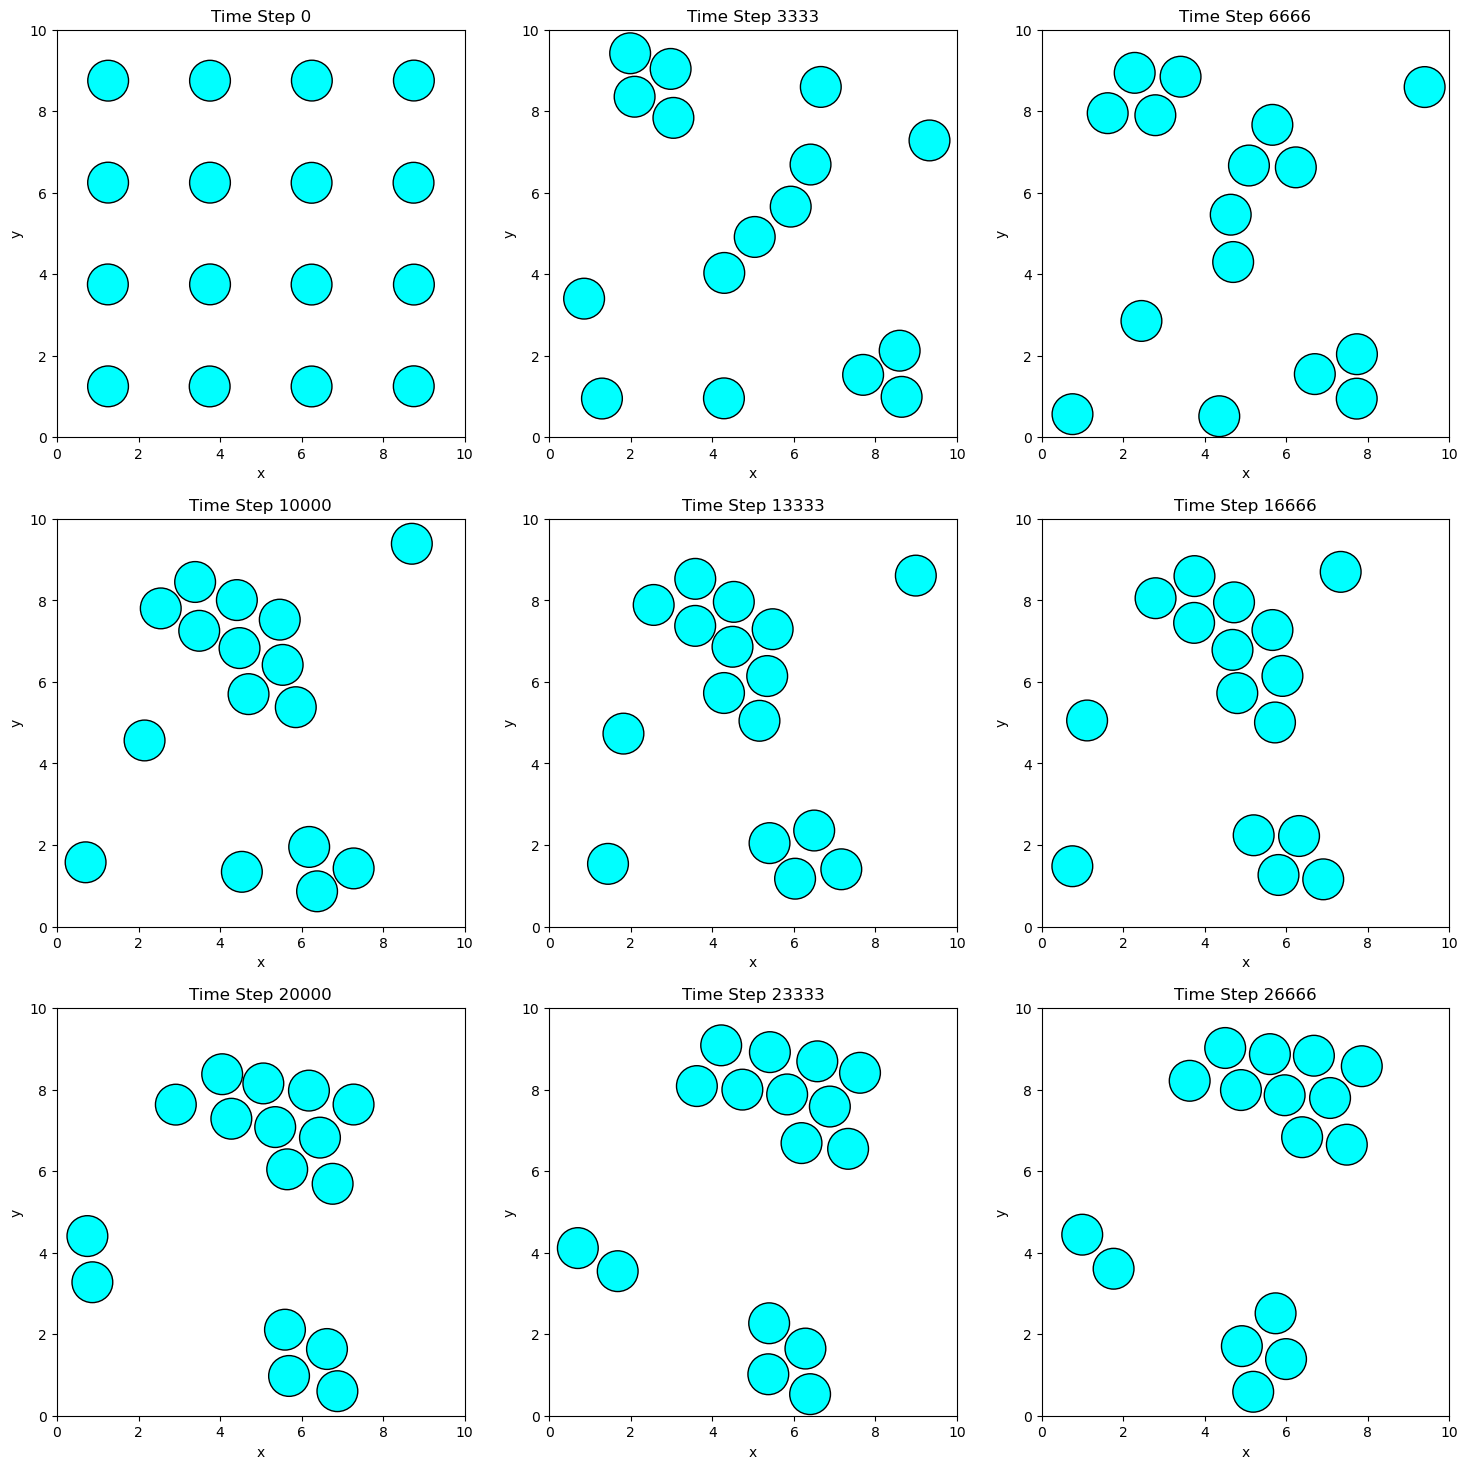

In [9]:
fig, axs = plt.subplots(3, 3, figsize=(18, 18))

for i, ax in enumerate(axs.flat):
    plot_positions(positions_history[i * n_steps // 9], ax, f'Time Step {i * n_steps // 9}')

plt.show()

The snapshots illustrate how particles move and interact under the influence of the Lennard-Jones potential and the Andersen thermostat. Over time, the particles begin to form clusters because their initial separation distances are **greater than the equilibrium distance** of the Lennard-Jones potential, and the [temperature is relatively low](https://en.wikipedia.org/wiki/Lennard-Jones_potential#Thermophysical_properties_of_the_Lennard-Jones_substance). As the simulation progresses, the **attractive forces dominate**, drawing the particles closer together to minimize the system's potential energy.

If the simulation were run for a longer duration, the particles would eventually coalesce into a single cluster. **This aggregation is driven by the particles seeking the potential energy minimum at the equilibrium separation distance.** Notice how the particles arrange themselves in a **hexagonally close-packed structure**, which is a common configuration in 2D systems with spherically symmetric interactions like the Lennard-Jones potential.

```{admonition} Limitations of the Andersen Thermostat
:class: warning

- **Momentum Conservation:** As previously noted, the Andersen thermostat does not conserve total momentum, which can impact transport properties.
- **Dynamics Alteration:** Frequent velocity reassignment can disrupt the natural dynamics of the system, potentially affecting time-correlation functions.
```

```{admonition} Alternatives
:class: tip

- **Nosé-Hoover Thermostat:** A deterministic thermostat that maintains momentum conservation and better preserves dynamic properties.
- **Langevin Dynamics:** Incorporates friction and random forces, suitable for modeling systems in contact with a heat bath while maintaining some dynamical features.
```

## Summary

In this lecture, we explored the concept of **thermostatting** in molecular dynamics simulations, focusing on the **Andersen thermostat**. We discussed how the Andersen thermostat maintains constant temperature by randomly reassigning particle velocities, simulating collisions with a heat bath.

We implemented the Andersen thermostat in combination with the **velocity Verlet algorithm** for a 2D system of particles interacting via the Lennard-Jones potential. Through the simulation, we observed how the thermostat controls the temperature and affects energy conservation.

The results demonstrated effective temperature regulation and provided insights into the behavior of particles under thermostatting. We also discussed the limitations of the Andersen thermostat and briefly introduced alternative methods.